In [10]:
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from soilgasflux_fcs import json_reader, models, metrics
import xarray as xr
from scipy.stats import binned_statistic
import warnings
from soilgasflux_fcs import pareto
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
processed_data_path = pathlib.Path('/Users/alexnaokiasatokobayashi/Documents/FCS/processed_data/')

test_number = 6
normalizationType = 'no' #['no', 'len', 'yRange']
# add_info = '_ln_v2test4' #['', '_ln_v2', '_ln_v2test0]
add_info = '_test5'

filename_regular = f'test{test_number:02}_{normalizationType}Norm{add_info}_2025-05-08.nc'
filename_mc = f'test{test_number:02}_MC_{normalizationType}Norm{add_info}_2025-05-08.nc'
filename_expected = f'expected_test{test_number:02}_2025-05-08.nc'
print(filename_regular)
print(filename_mc)
print(filename_expected)

ds = xr.open_dataset(processed_data_path / filename_regular)
dsMC = xr.open_dataset(processed_data_path / filename_mc)
expected_ds = xr.open_dataset(processed_data_path / filename_expected)

test06_noNorm_test5_2025-05-08.nc
test06_MC_noNorm_test5_2025-05-08.nc
expected_test06_2025-05-08.nc


In [34]:
test_a = expected_ds.isel(cutoff=0)['dcdt(HM)'].values
binned_statistic(test_a, test_a, bins=3)[2]
# Define your intensity categories
intensity_labels = ['low', 'medium', 'high']

# Calculate bin indices (0, 1, or 2)
bin_indices = binned_statistic(test_a, test_a, bins=3)[2] - 1  # -1 because bins are 1-indexed

# Map indices to labels
intensity_categories = np.array(intensity_labels)[bin_indices]
group_intensity = xr.DataArray(
    intensity_categories,
    coords={'time': expected_ds['time']},
    dims=['time']
)

expected_ds = expected_ds.assign_coords(intensity_categories=group_intensity)

In [35]:
cm = 1/2.54

6 12
6 12
6 12

Deadband: 40
Cutoff: 160

Deadband: 20
Cutoff: 90

Deadband: 40
Cutoff: 100

Deadband: 20
Cutoff: 110

Deadband: 10
Cutoff: 110


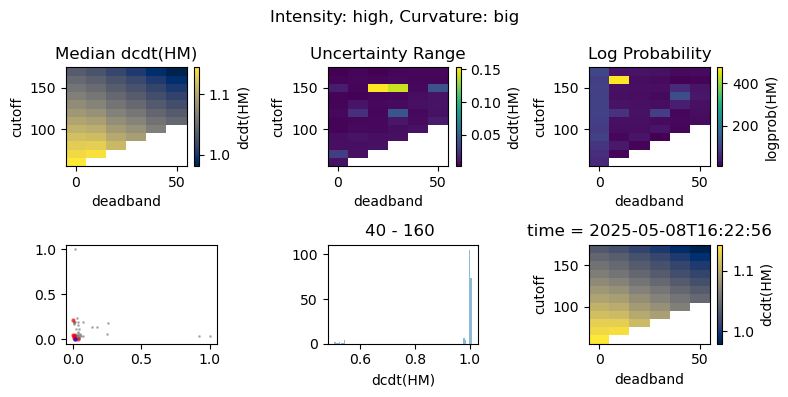

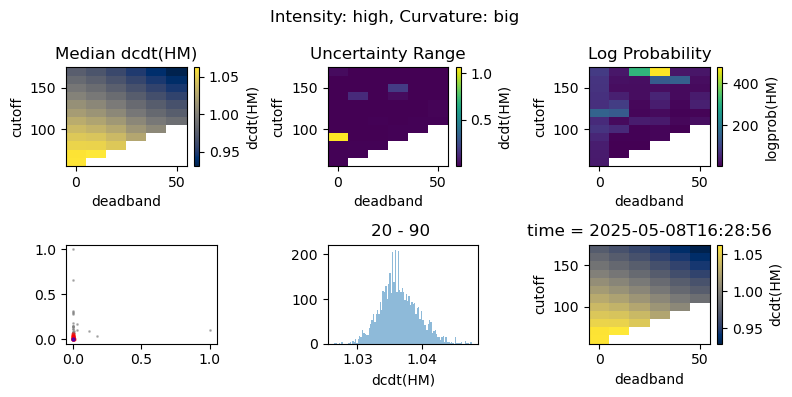

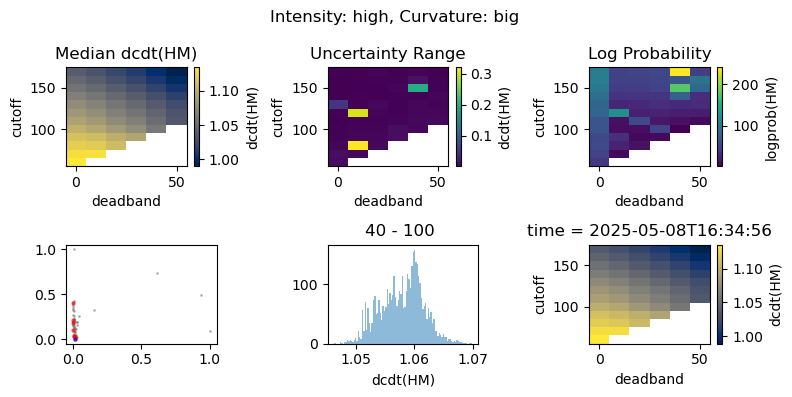

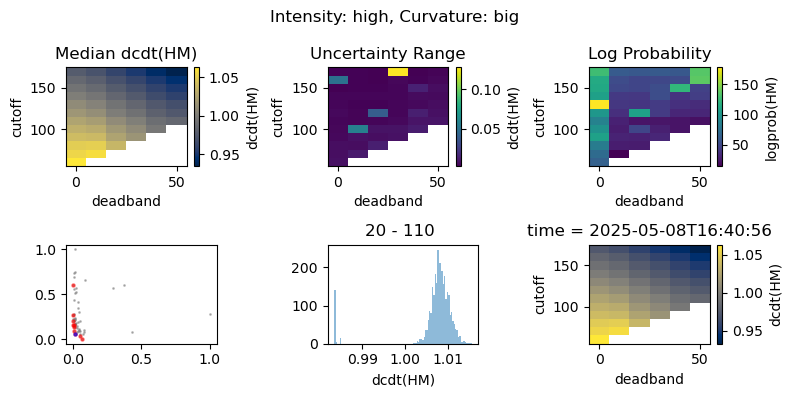

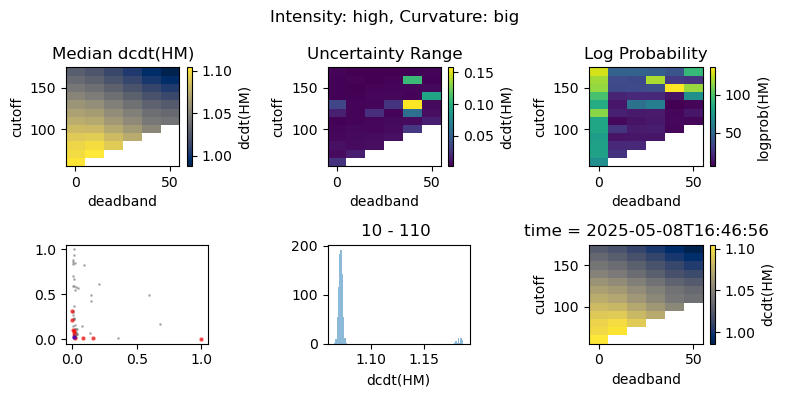

In [36]:
for intensity in ['low', 'medium','high']:
    time_intensity = expected_ds.where(expected_ds['intensity_categories'] == intensity, drop=True)
    cutoff_coords, deadband_coords = dsMC.coords['cutoff'], dsMC.coords['deadband']
    print(len(deadband_coords), len(cutoff_coords))


    for curve in np.unique(time_intensity['curvature'].values):
        all_time_selection = expected_ds.where((expected_ds['intensity_categories'] == intensity) & 
                                               (expected_ds['curvature'] == curve), drop=True).time.values
        

        if intensity != 'high': # ['low', 'high']
            continue
        if curve != 'big': # ['straight', 'big']
            continue
        
        for time_selection in all_time_selection:
            try:
                print()
                fig, ax = plt.subplots(2, 3, figsize=(8, 4))
                
                mc_hm = dsMC.sel(time=time_selection).median(dim=['MC'])['dcdt(HM)']
                #### Pareto analysis ####
                pa = pareto.Pareto(dsMC=dsMC.sel(time=time_selection))
                Norm_uncertaintyRange, Norm_logprob, flatNorm_uncertaintyRange, flatNorm_logprob = pa.prepare_metrics()
                pareto_uncertaintyRange_logprob = pa.find_pareto_front(x=flatNorm_uncertaintyRange,
                                                                       y=flatNorm_logprob, 
                                                                       maximize_x=False, maximize_y=False)
                coords_pareto_uncertaintyRange_logprob = pa.get_coords_pareto(pareto_indices=pareto_uncertaintyRange_logprob)
                
                best_pareto_x, best_pareto_y = pa.get_best_from_pareto(pareto_indices=pareto_uncertaintyRange_logprob,
                                                                       metric_x=Norm_uncertaintyRange,
                                                                       metric_y=Norm_logprob)
                uncertaintyRange_hm = pa.uncertaintyRange
                logprob_hm = pa.logprob
                ##########################
                print('Deadband:', deadband_coords[best_pareto_y].values)
                print('Cutoff:', cutoff_coords[best_pareto_x].values)
                # print('try Deadband:', deadband_coords[best_pareto_x].values)
                # print('try Cutoff:', cutoff_coords[best_pareto_y].values)
                

                hist_dcdt = dsMC.sel(time=time_selection,
                                     deadband=deadband_coords[best_pareto_y].values,
                                     cutoff=cutoff_coords[best_pareto_x].values)['dcdt(HM)']
                
                


                arbitrary_results = {'deadband':[0, 0, 30, 50, 0, 30, 50],
                                     'cutoff':[60, 60,120,170,60,120,170],  
                                     'dcdt(HM)':[], 'dcdt(linear)':[], 'R2':[]}

                                

                #### Plots ####
                ds.sel(time=time_selection)['dcdt(HM)'].plot(ax=ax[0, 0], cmap='cividis')
                # dsMC.sel(time=time_selection)['dcdt(HM)'].median(dim='MC').plot(ax=ax[0, 0], cmap='cividis')
                uncertaintyRange_hm.plot(ax=ax[0, 1], cmap='viridis', 
                                        #  vmin=uncertaintyRange_hm.quantile(0.16),
                                        #    vmax=uncertaintyRange_hm.quantile(0.84)
                                           )
                logprob_hm.plot(ax=ax[0, 2], cmap='viridis')
                

                ax[1,0].scatter(flatNorm_uncertaintyRange, flatNorm_logprob, s=1, c='gray', alpha=0.5)

                ax[1,0].scatter(Norm_uncertaintyRange[coords_pareto_uncertaintyRange_logprob], 
                                Norm_logprob[coords_pareto_uncertaintyRange_logprob], 
                                s=5, c='red', alpha=0.5)
                
                # print(np.shape(Norm_uncertaintyRange), np.shape(Norm_logprob))
                # print(Norm_uncertaintyRange[:,1])
                # print('best_pareto_x:', best_pareto_x, 'best_pareto_y:', best_pareto_y)

                ax[1,0].scatter(Norm_uncertaintyRange[best_pareto_x, best_pareto_y], 
                                Norm_logprob[best_pareto_x, best_pareto_y], 
                                s=5, c='blue', alpha=0.5)
                
                # ax[1,1].hist(hist_dcdt, density=True, alpha=0.5)
                hist_dcdt.plot.hist(bins=100, density=True, alpha=0.5, ax=ax[1,1])
                
                #### Arbitrary deadband and cutoff
                # ds.sel(time=time_selection,
                #        deadband=0, cutoff=60)['dcdt(HM)'].plot()
                ##################################


                dsMC.sel(time=time_selection)['dcdt(HM)'].median(dim='MC').plot(ax=ax[1,2], cmap='cividis')

                fig.suptitle(f'Intensity: {intensity}, Curvature: {curve}')

                ax[0,0].set_title('Median dcdt(HM)')
                ax[0,1].set_title('Uncertainty Range')
                ax[0,2].set_title('Log Probability')
                ax[1,1].set_title(f'{deadband_coords[best_pareto_y].values} - {cutoff_coords[best_pareto_x].values} ')
                fig.tight_layout()
                fig.show()
                # break
            except Exception as e:
                print('Error in plotting')
                print(e)
                continue